<a href="https://colab.research.google.com/github/kushjaggi/Nifty50Edge/blob/main/Nifty50Edge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NiftyForecaster==>Uses supervised learning with linear and logistic regression

## Importing the Requisite Libraries

In [ ]:
import pandas as pd
import numpy as np
import math
import yfinance as yf
import quantstats as qs
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')


'''
import pandas as pd: Pandas is a popular Python library for data manipulation and analysis. It provides data structures like DataFrame, which is ideal for working with structured data.

import numpy as np: NumPy is a fundamental package for numerical computing in Python. It provides support for arrays, matrices, and mathematical functions to operate on these data structures.

import math: The math module in Python provides mathematical functions, including trigonometric, logarithmic, and exponential functions.

import yfinance as yf: yfinance is a Python library that allows you to download historical market data from Yahoo Finance. It's commonly used for fetching stock data for analysis.

import quantstats as qs: QuantStats is a Python library for quantitative financial analysis. It provides tools and functions to analyze investment portfolios, calculate performance metrics, and visualize results.

from sklearn.linear_model import LinearRegression: scikit-learn is a popular machine learning library in Python. LinearRegression is a class in scikit-learn used for linear regression modeling, a fundamental technique in predictive analytics.

from sklearn.linear_model import LogisticRegression: Similarly, LogisticRegression is a class in scikit-learn used for logistic regression, a technique often used for binary classification problems.

import warnings: The warnings module allows you to handle warning messages generated during program execution. In this case, you've imported it to filter out warnings.
'''

# Linear Regression Function

In [ ]:
def linear_regression(train, test):

    # Creating the columns of independent variables
    train['H-C'] = train['High'] - train['Close']
    train['C-L'] = train['Close'] - train['Low']
    train['H-Ht-1'] = train['High'] - train['High'].shift(1)
    train['L-Lt-1'] = train['Low'] - train['Low'].shift(1)

    # Defining the X and Y variable for input in the regression model
    x = train[['H-C', 'C-L', 'H-Ht-1', 'L-Lt-1']].iloc[:-1].dropna()
    y = train[['Close']].shift(-1).iloc[1:-1]

    # Creating the object and using the fit function to generate the betas
    model = LinearRegression()
    model.fit(x, y)

    # Defining the same independent variable columns as for the test data set
    test['H-C'] = test['High'] - test['Close']
    test['C-L'] = test['Close'] - test['Low']
    test['H-Ht-1'] = test['High'] - test['High'].shift(1)
    test['L-Lt-1'] = test['Low'] - test['Low'].shift(1)
    test.dropna(inplace=True)

    # Creating the predicted value column by doing a sumproduct of the betas and the respective independent variable
    test['Predicted'] = test['Close'] + \
                        test['H-C'] * model.coef_[0][0] + \
                        test['C-L'] * model.coef_[0][1] + \
                        test['H-Ht-1'] * model.coef_[0][2] + \
                        test['L-Lt-1'] * model.coef_[0][3]

    # Defining the entry logic
    test['Entry'] = np.where(test['Predicted'] > test['Predicted'].shift(1), test['Close'], 0)

    # Defining the exit logic
    test['Exit'] = np.where((test['Entry'] != 0) & (test['Open'].shift(-1) < test['Close']),
                             test['Open'].shift(-1), 0)

    test['Exit'] = np.where((test['Entry'] != 0) & (test['Open'].shift(-1) > test['Close']),
                             test['Close'].shift(-1), test['Exit'])

    # Calculating the P&L on an MTM basis
    test['P&L'] = test['Exit'] - test['Entry']

    # Generating the equity curve of the strategy
    test['Equity curve'] = test['P&L'].cumsum() + int(test['Close'][0])

    # Plotting the equity curve of the strategy against the benchmark
    test[['Equity curve', 'Close']][:-1].plot()

    return test.iloc[:-1]


'''
The linear_regression function you provided implements a simple linear regression-based trading strategy using the difference between High, Low, and Close prices as independent variables to predict the next day's Close price. Here's a breakdown of the steps within the function:

Feature Engineering: Compute differences between High and Close prices (H-C), Close and Low prices (C-L), High of the current day and the previous day (H-Ht-1), and Low of the current day and the previous day (L-Lt-1) for both the training and test datasets.

Data Preparation: Define the independent variables (x) using the engineered features.Define the target variable (y) as the Close price of the next day.

Model Training: Create a Linear Regression model and fit it using the independent variables (x) and the target variable (y).

Prediction: Use the trained model to predict the Close price for the test dataset based on the engineered features.

Entry and Exit Logic: Determine the entry logic based on whether the predicted Close price is greater than the previous day's predicted Close price. Define the exit logic based on whether the Close price of the next day is less than the predicted Close price.

Profit and Loss (P&L) Calculation:Calculate the Profit and Loss (P&L) based on the entry and exit logic.

Equity Curve and Plotting: Generate the equity curve of the trading strategy by cumulatively summing the P&L.
Plot the equity curve against the Close prices.

Return Processed Data: Return the processed data for further analysis or visualization.
This function essentially defines a simple trading strategy using a linear regression model, where the model predicts the next day's Close price based on the engineered features. The strategy determines when to enter and exit positions based on the predicted and actual Close prices.

Linear regression is a statistical and machine learning technique used to model the relationship between a single independent variable (often denoted as "X") and a dependent variable (often denoted as "y") by fitting a linear equation to observed data. The goal of linear regression is to find the best-fitting straight line (or hyperplane in higher dimensions) that minimizes the difference between the predicted values and the actual values.
The linear regression model can be represented by the equation:

y=mx+b

where:
�y is the dependent variable (the variable we want to predict),
�x is the independent variable (the input feature),
�m is the slope of the line (represents the change in y for a unit change in x),
�b is the y-intercept (the value of y when x is zero).
'''

# Logistic Regression Function

In [ ]:
def logistic_regression(train, test):

    # Creating the columns of independent variables as dummy variables
    train['C-L > H-C'] = np.where((train['Close'] - train['Low']) > (train['High'] - train['Close']), 1, 0)
    train['H > Ht-1'] = np.where(train['High'] > train['High'].shift(1), 1, 0)
    train['L > Lt-1'] = np.where(train['Low'] > train['Low'].shift(1), 1, 0)
    train['Ct+1 > C'] = np.where(train['Close'].shift(-1) > train['Close'], 1, 0)

    train = train[1:]

    # Defining the X and Y variable for input in the regression model
    x = train[['C-L > H-C', 'H > Ht-1', 'L > Lt-1']]
    y = train[['Ct+1 > C']]

    # Creating the object and using the fit function to generate the betas
    model = LogisticRegression()
    model.fit(x, y)

    # Defining the same independent variable columns as for the test data set
    test['C-L > H-C'] = np.where((test['Close'] - test['Low']) > (test['High'] - test['Close']), 1, 0)
    test['H > Ht-1'] = np.where(test['High'] > test['High'].shift(1), 1, 0)
    test['L > Lt-1'] = np.where(test['Low'] > test['Low'].shift(1), 1, 0)

    # Creating the Z-value column by doing a sumproduct of the betas and the respective independent variable
    test['Z'] = model.intercept_ + \
                test['C-L > H-C'] * model.coef_[0][0] + \
                test['H > Ht-1'] * model.coef_[0][1] + \
                test['L > Lt-1'] * model.coef_[0][2]

    # Converting the linear Z equation into probability using the sigmoid function
    test['Probability'] = np.exp(test['Z']) / (1 + np.exp(test['Z']))

    test = test[1:]

    # Defining the entry logic
    test['Entry'] = np.where(test['Probability'] > 0.5, test['Close'], 0)

    # Defining the exit logic
    test['Exit'] = np.where((test['Entry'] != 0) & (test['Open'].shift(-1) < test['Close']),
                             test['Open'].shift(-1), 0)

    test['Exit'] = np.where((test['Entry'] != 0) & (test['Open'].shift(-1) > test['Close']),
                             test['Close'].shift(-1), test['Exit'])

    # Calculating the P&L on an MTM basis
    test['P&L'] = test['Exit'] - test['Entry']

    # Generating the equity curve of the strategy
    test['Equity curve'] = test['P&L'].cumsum() + int(test['Close'][0])

    # Plotting the equity curve of the strategy against the benchmark
    test[['Equity curve', 'Close']].iloc[:-1].plot()

    return test.iloc[:-1]

'''
The logistic_regression function you provided implements a logistic regression-based trading strategy. Here's a breakdown of the steps within the function:

Feature Engineering:

Create binary features based on conditions involving the Close, High, and Low prices to serve as independent variables.
Data Preparation:

Define the independent variables (x) using the engineered binary features.
Define the target variable (y) as a binary indicator indicating whether the Close price of the next day is greater than the current Close price.
Model Training:

Create a Logistic Regression model and fit it using the independent variables (x) and the target variable (y).
Prediction:

Use the trained model to predict the probability of the Close price of the next day being higher than the current Close price.
Entry and Exit Logic:

Determine the entry logic based on whether the predicted probability exceeds a threshold (0.5 by default).
Define the exit logic based on whether the Close price of the next day is higher or lower than the current Close price.
Profit and Loss (P&L) Calculation:

Calculate the Profit and Loss (P&L) based on the entry and exit logic.
Equity Curve and Plotting:

Generate the equity curve of the trading strategy by cumulatively summing the P&L.
Plot the equity curve against the Close prices.
Return Processed Data:

Return the processed data for further analysis or visualization.
This function defines a trading strategy using logistic regression, where the model predicts the probability of the next day's Close price being higher than the current Close price. The strategy determines when to enter and exit positions based on the predicted probabilities.

Logistic regression is a statistical method used for binary classification tasks, where the target or dependent variable is categorical and has two possible outcomes, usually represented as 0 and 1. It's named "logistic regression" because it's an extension of linear regression but uses the logistic function (or sigmoid function) to model the relationship between the independent variables and the probability of a particular outcome.

In logistic regression, the goal is to predict the probability that a given input data point belongs to a certain class. The logistic function (sigmoid function) is used to map any real-valued number to the range [0, 1], making it suitable for modeling probabilities.

Logistic regression predicts the probability of the target belonging to the positive class (e.g., class 1) and, based on a chosen threshold (usually 0.5), classifies the instance into one of the two classes. If the predicted probability is greater than or equal to the threshold, the instance is classified as the positive class; otherwise, it's classified as the negative class.

Logistic regression is widely used in various fields, including finance, healthcare, marketing, and more, for tasks like predicting whether a customer will buy a product, whether a patient has a particular disease, or whether an email is spam or not.
'''


# Performance Analysis using Quantstats

In [ ]:
def performance_analysis(df):
    df['Returns'] = df['Equity curve']/df['Equity curve'].shift(1) - 1
    qs.reports.full(df['Returns'])

'''
The performance_analysis function computes the returns from the 'Equity curve' column in the DataFrame and then utilizes the quantstats library to generate a full performance report based on the returns. Here's a description of the function:

Calculating Returns:

The function first computes the daily returns using the 'Equity curve' values. It divides each 'Equity curve' value by the previous day's 'Equity curve' value and subtracts 1 to calculate the daily return. These returns are stored in a new column called 'Returns'.
Generating Performance Report:

After calculating the returns, the quantstats.reports.full function from the quantstats library is used to generate a comprehensive performance report based on the returns. This report includes various metrics and statistics related to the returns, providing insights into the performance of the trading strategy.
The quantstats library is used to analyze and evaluate the performance of the trading strategy, providing valuable metrics and statistics that help in assessing the strategy's profitability and risk
'''

# Calling the Respective Functions

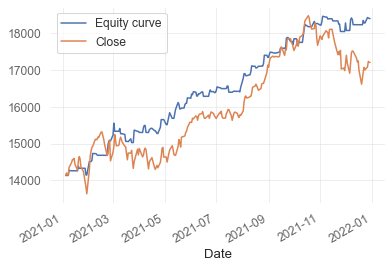

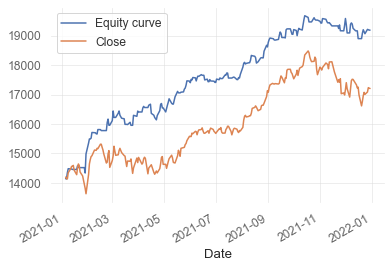

In [ ]:
year = 2020

train = pd.read_excel(f'{year}.xlsx', parse_dates=True)
test = pd.read_excel(f'{year+1}.xlsx', parse_dates=True)
train.set_index('Date', inplace=True)
test.set_index('Date', inplace=True)

linear = linear_regression(train, test)
logistic = logistic_regression(train, test)

'''
Data is loaded from Excel files for the specified year and the following year. Then, two functions, linear_regression and logistic_regression, are called to perform linear regression and logistic regression, respectively, on the training and test datasets.

Here's a breakdown of the code:

Load Data:

Data is loaded from Excel files for the specified year and the following year using Pandas read_excel function. The parse_dates=True argument is used to parse date columns.
Set Index:

The 'Date' column is set as the index for both the training and test datasets using the set_index function.
Linear Regression:

The linear_regression function is called with the training and test datasets for linear regression analysis. This function calculates linear regression based on specified independent variables and generates an equity curve for the strategy.
Logistic Regression:

The logistic_regression function is called with the training and test datasets for logistic regression analysis. This function calculates logistic regression and generates an equity curve for the strategy.
The variables linear and logistic hold the respective outputs of the regression functions, which likely include processed information about the strategy's performance based on the specified methods (linear or logistic regression).
'''

                           Strategy
-------------------------  ----------
Start Period               2021-01-04
End Period                 2021-12-30
Risk-Free Rate             0.0%
Time in Market             56.0%

Cumulative Return          30.21%
CAGR﹪                     30.69%

Sharpe                     3.12
Prob. Sharpe Ratio         99.69%
Smart Sharpe               2.98
Sortino                    6.21
Smart Sortino              5.93
Sortino/√2                 4.39
Smart Sortino/√2           4.19
Omega                      2.08

Max Drawdown               -3.38%
Longest DD Days            55
Volatility (ann.)          8.8%
Calmar                     9.07
Skew                       1.07
Kurtosis                   3.68

Expected Daily %           0.11%
Expected Monthly %         2.22%
Expected Yearly %          30.21%
Kelly Criterion            26.31%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.8%
Expected Shortfall (cVaR)  -0.8%

Max Consecutive Wins       3
Ma

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-03-03,2021-03-23,2021-04-27,55,-3.382851,-3.228866
2,2021-11-08,2021-11-29,2021-12-30,52,-2.252121,-2.236955
3,2021-01-20,2021-01-28,2021-02-01,12,-1.649950,-0.377896
4,2021-09-27,2021-10-05,2021-10-12,15,-1.173379,-1.077764
5,2021-05-18,2021-05-19,2021-05-28,10,-1.077154,-0.938166


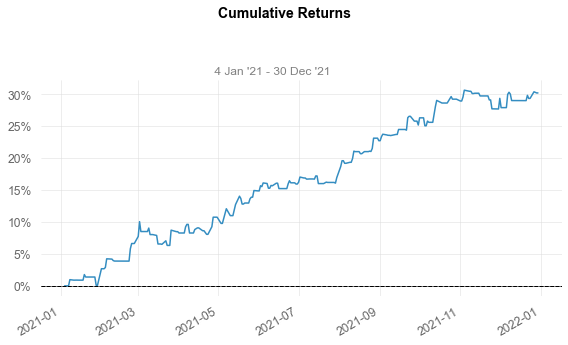

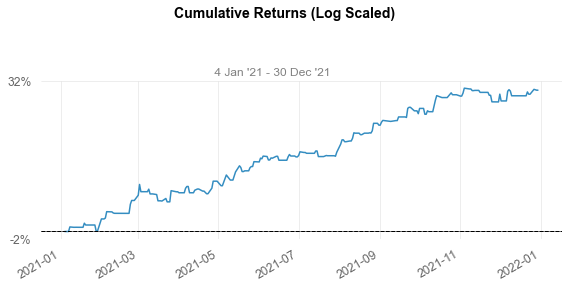

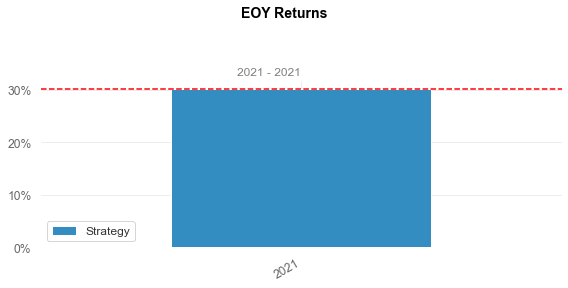

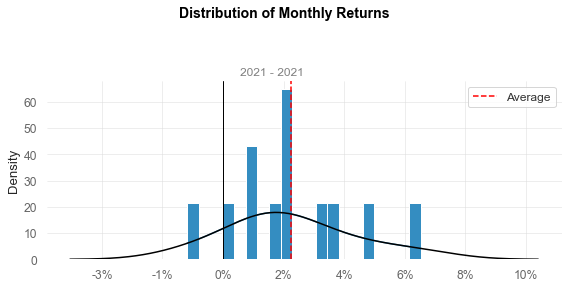

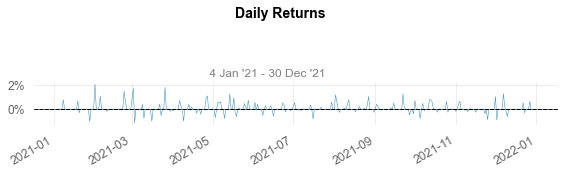

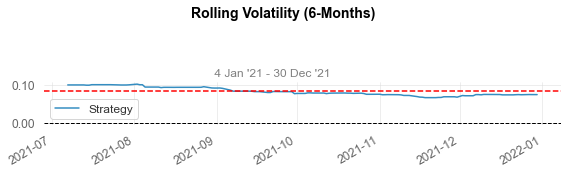

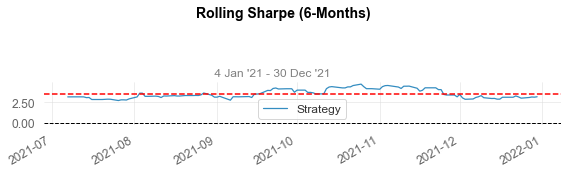

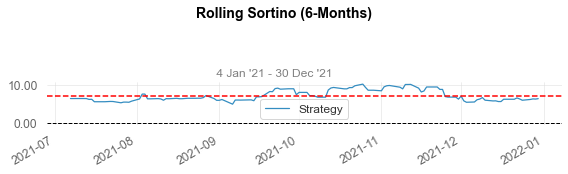

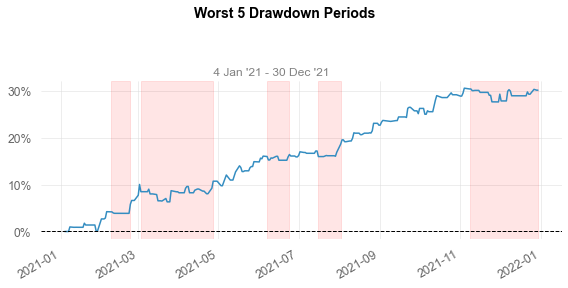

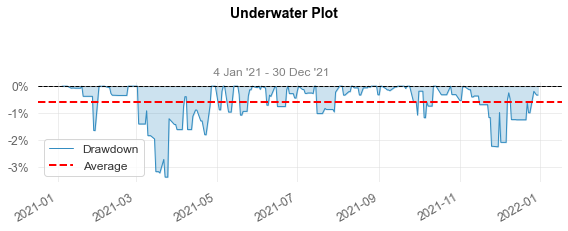

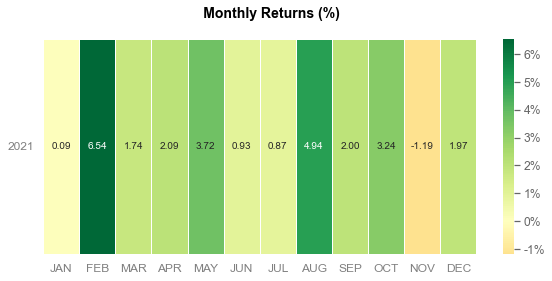

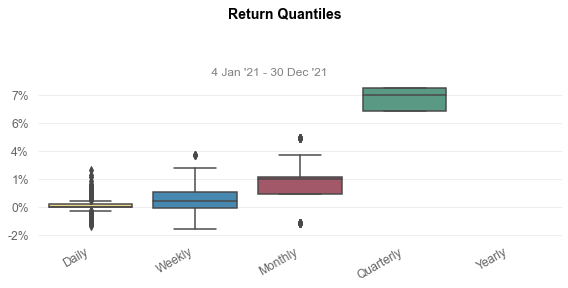

In [ ]:
performance_analysis(linear)

                           Strategy
-------------------------  ----------
Start Period               2021-01-05
End Period                 2021-12-30
Risk-Free Rate             0.0%
Time in Market             78.0%

Cumulative Return          35.61%
CAGR﹪                     36.3%

Sharpe                     2.96
Prob. Sharpe Ratio         99.42%
Smart Sharpe               2.59
Sortino                    5.76
Smart Sortino              5.03
Sortino/√2                 4.07
Smart Sortino/√2           3.56
Omega                      1.83

Max Drawdown               -3.95%
Longest DD Days            73
Volatility (ann.)          10.77%
Calmar                     9.19
Skew                       1.36
Kurtosis                   7.43

Expected Daily %           0.12%
Expected Monthly %         2.57%
Expected Yearly %          35.61%
Kelly Criterion            22.12%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.99%
Expected Shortfall (cVaR)  -0.99%

Max Consecutive Wins       6

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-10-18,2021-12-16,2021-12-30,73,-3.949124,-3.100687
2,2021-04-16,2021-04-22,2021-04-28,12,-3.187080,-2.708433
3,2021-03-03,2021-03-23,2021-04-06,34,-2.952294,-2.806626
4,2021-04-29,2021-05-03,2021-05-06,7,-1.708378,-0.981479
5,2021-01-20,2021-01-28,2021-01-29,9,-1.674987,-0.420376


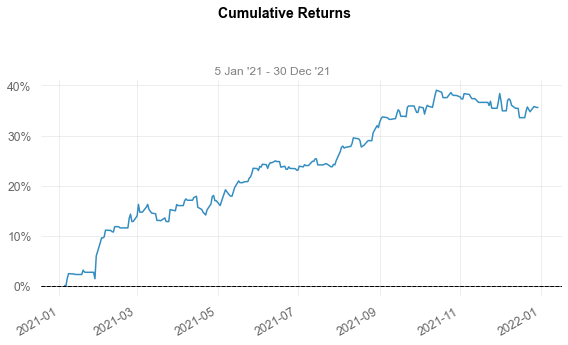

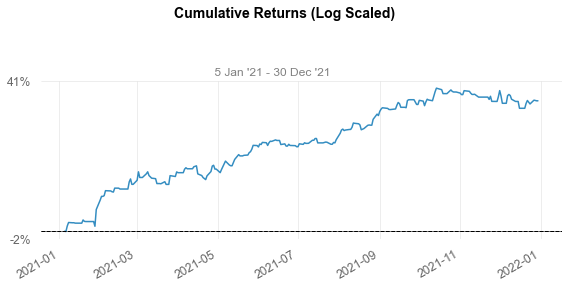

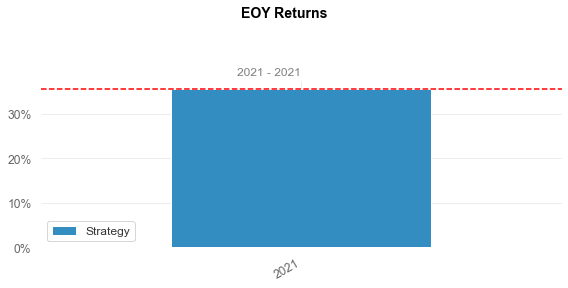

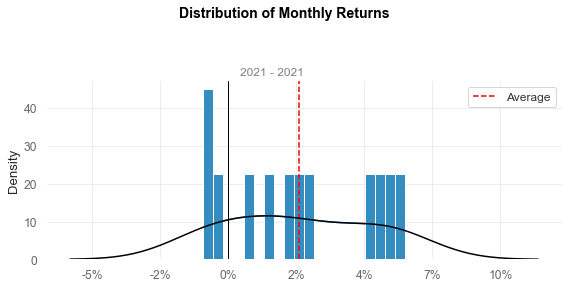

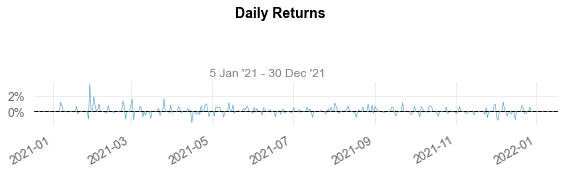

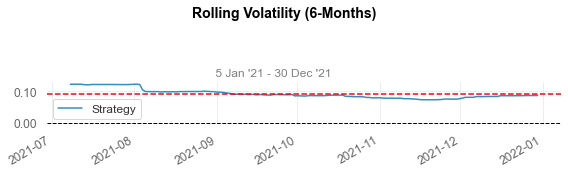

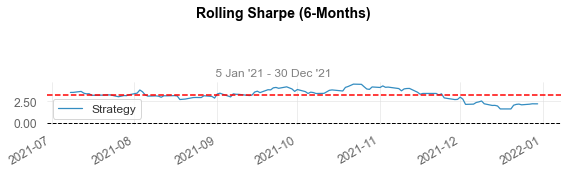

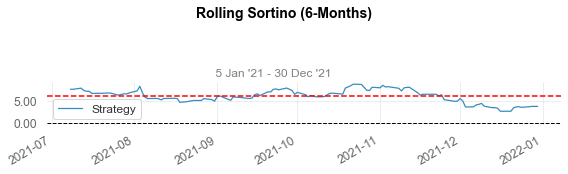

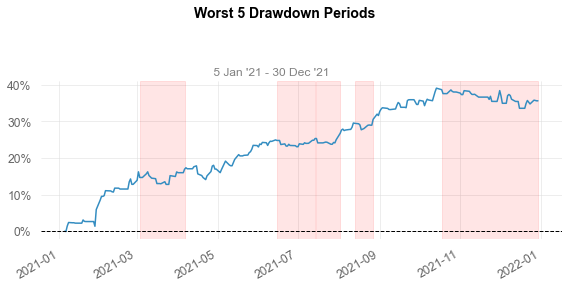

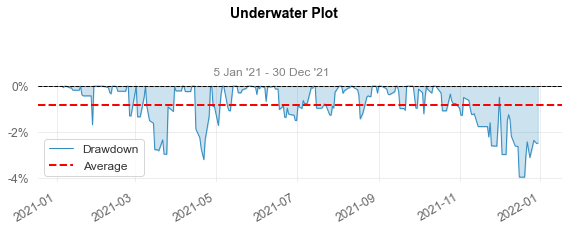

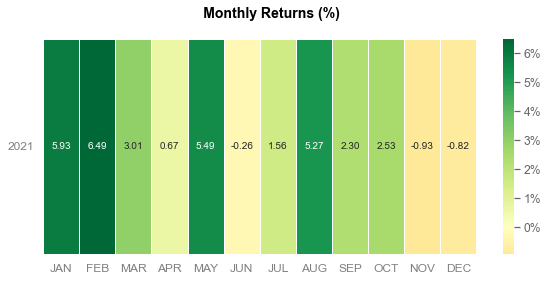

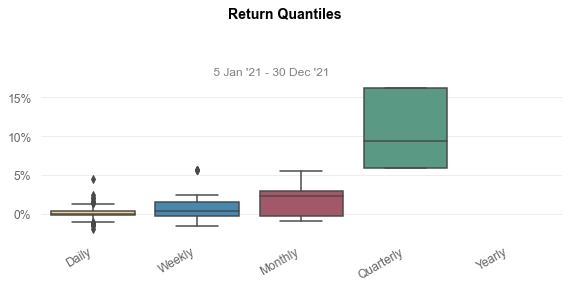

In [ ]:
performance_analysis(logistic)